In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew
from lifelines import LogNormalAFTFitter
from lifelines import WeibullAFTFitter
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines.utils import k_fold_cross_validation
from lifelines import KaplanMeierFitter
import joblib

In [2]:
# import data 

df = pd.read_csv('telecom_customer_churn_cleaned_encoded.csv')

In [3]:
df.columns

Index(['Age', 'Number_of_Dependents', 'Number_of_Referrals',
       'Tenure_in_Months', 'Avg_Monthly_Long_Distance_Charges',
       'Avg_Monthly_GB_Download', 'Num_Internet_Features',
       'Has_Multiple_Lines', 'Churn_status', 'gender_e', 'married_e',
       'paper_e', 'offer_e', 'Contract_e', 'Payment_Method_e',
       'Internet_Type_DSL', 'Internet_Type_Fiber Optic'],
      dtype='object')

In [4]:
# Duration and event columns 

duration_col = 'Tenure_in_Months' 
event_col = 'Churn_status' 

In [5]:
df.head()

,Age,Number_of_Dependents,Number_of_Referrals,Tenure_in_Months,Avg_Monthly_Long_Distance_Charges,Avg_Monthly_GB_Download,Num_Internet_Features,Has_Multiple_Lines,Churn_status,gender_e,married_e,paper_e,offer_e,Contract_e,Payment_Method_e,Internet_Type_DSL,Internet_Type_Fiber Optic
0,37,0,2,9,42.39,16.0,5.0,1.0,0,0,1,1,0,1,1,0,0
1,46,0,0,9,10.69,10.0,3.0,2.0,0,1,0,0,0,0,1,0,0
2,50,0,0,4,33.65,30.0,3.0,1.0,1,1,0,1,1,0,0,0,1
3,78,0,1,13,27.82,4.0,6.0,1.0,1,1,1,1,1,0,0,0,1
4,75,0,3,3,7.38,11.0,4.0,1.0,1,0,1,1,0,0,1,0,1


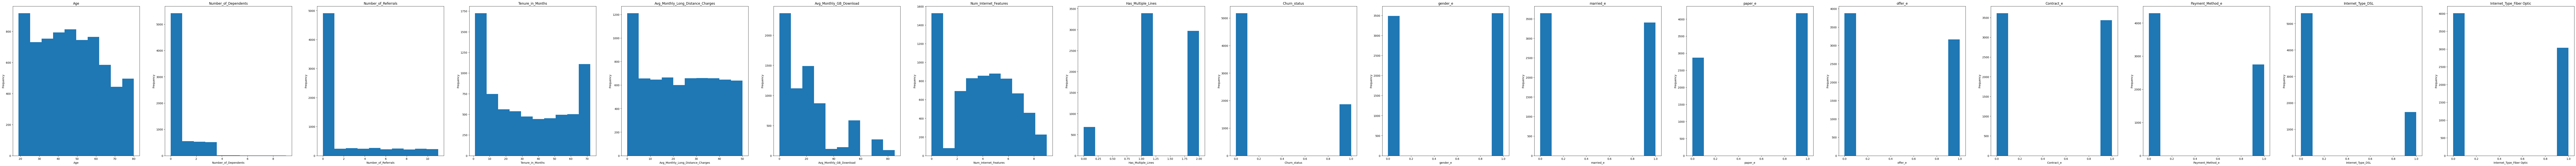

In [6]:
# getting all the numeric columns (Checking the distr of numerical collumns)

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

fig,ax = plt.subplots(1,len(numeric_columns),figsize=(len(numeric_columns)*10 , 10))

for i, col in enumerate(numeric_columns):
    ax[i].hist(df[col])
    ax[i].set_title(col)  
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frequency')
plt.show()



In [7]:
# removing a few columns

""" 
Removed overly skewed numeric categorical variables because they tend to impact linear realtionship with Log(T) . 
Ideally they should be transformed if they are to be used. Using them as is leads to violation of assumption (normally distirbuted residuals) and large -ve or +ve residuals 
Residuals should have zero mean

"""

df.drop(columns=['Number_of_Dependents' , 'Number_of_Referrals', 'Num_Internet_Features' , 'Avg_Monthly_GB_Download' , 'Avg_Monthly_Long_Distance_Charges' , 'Has_Multiple_Lines' , 'Internet_Type_DSL'] , inplace = True)

#  add a interactionm term ( to see if can improve the residual distr by capturing any interaction effects)

#df['contract_cross'] = df['Contract_e'] * df['married_e']



In [8]:
df.columns

Index(['Age', 'Tenure_in_Months', 'Churn_status', 'gender_e', 'married_e',
       'paper_e', 'offer_e', 'Contract_e', 'Payment_Method_e',
       'Internet_Type_Fiber Optic'],
      dtype='object')

In [18]:
# dump the data 

df.to_csv('telecom_customer_churn_cox_ph_cleaned.csv', index=False)

In [9]:
# fit the Lognormal AFT model

aft = LogNormalAFTFitter()

# Train and test model using cross-validation

# Run 5-fold CV on full dataset
cv_scores = k_fold_cross_validation(
    aft, df, 
    duration_col=duration_col, 
    event_col=event_col, 
    k=5, 
    scoring_method="concordance_index"
)

# Report results
print(f"Cross-validated Concordance Index (mean over 5 folds): {np.mean(cv_scores):.3f}")
print("Individual fold scores:", np.round(cv_scores, 3))

# Fit on entire data for diagnostics
aft.fit(df, duration_col=duration_col, event_col=event_col)


Cross-validated Concordance Index (mean over 5 folds): 0.835
Individual fold scores: [0.843 0.827 0.838 0.837 0.831]


<lifelines.LogNormalAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [10]:
# Print model summary

print(aft.print_summary())

<lifelines.LogNormalAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'Tenure_in_Months'
                event col = 'Churn_status'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8998.93
         time fit was run = 2025-05-02 03:27:18 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                  
mu_    Age                       -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
       Contract_e                 3.18     24.13      0.08            3.03            3.33               20.74               28.07
       Internet_Type_Fiber Optic -0.20      0.82      0.06           -0.32           -0.07                0.72                0.93
       Payment_Method_e           0.57      1.78      0.07            0.44            0.71                1.55                2.03
       gender_e                   0.02      1.02      0.06           -0.09            0.14                0.91                1.15
       married_e                  0.84      2.31      0.06            0.72            0.96                2.04                2.60
       offer_e                   -0.02      0.98      0.06           -0.14            0.10                0.87                1.10
       paper_e                   -0.16      0.85      0.07           -0.29           -0.03                0.75                0.97
       Intercept                  3.26     26.01      0.11            3.03            3.48               20.78               32.56
sigma_ Intercept                  0.54      1.72      0.02            0.51            0.57                1.66                1.77

                                  cmp to     z      p  -log2(p)
param  covariate                                               
mu_    Age                          0.00 -4.04 <0.005     14.19
       Contract_e                   0.00 41.26 <0.005       inf
       Internet_Type_Fiber Optic    0.00 -3.11 <0.005      9.05
       Payment_Method_e             0.00  8.45 <0.005     54.92
       gender_e                     0.00  0.37   0.71      0.49
       married_e                    0.00 13.59 <0.005    137.34
       offer_e                      0.00 -0.34   0.73      0.45
       paper_e                      0.00 -2.44   0.01      6.11
       Intercept                    0.00 28.44 <0.005    588.42
sigma_ Intercept                    0.00 31.28 <0.005    711.25
---
Concordance = 0.84
AIC = 18017.87
log-likelihood ratio test = 3042.54 on 8 df
-log2(p) of ll-ratio test = inf

None


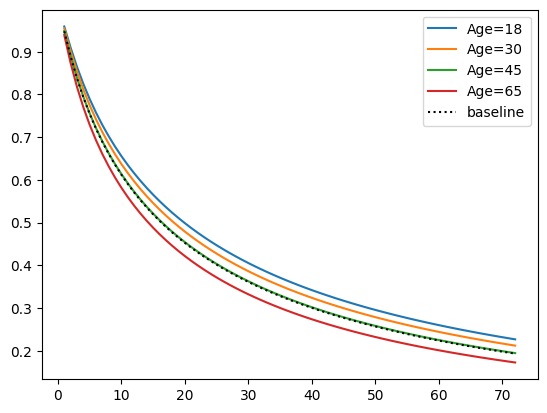

In [11]:
# Plotting partial effects of covariates

# Case 1 : Age (Covariate)

aft.plot_partial_effects_on_outcome(
    covariates=['Age'], 
    values=[18, 30 , 45 , 65], 
    plot_baseline=True
)
plt.show()

In [12]:
# Exporting the model ( To be used if building a GUI)

joblib.dump(aft, "aft_model.pkl")

['aft_model.pkl']

C:\Users\abhin\AppData\Local\Temp\ipykernel_16968\3279003551.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = np.exp(aft_model.params_.loc['sigma_'][0])


Skewness: 0.2580


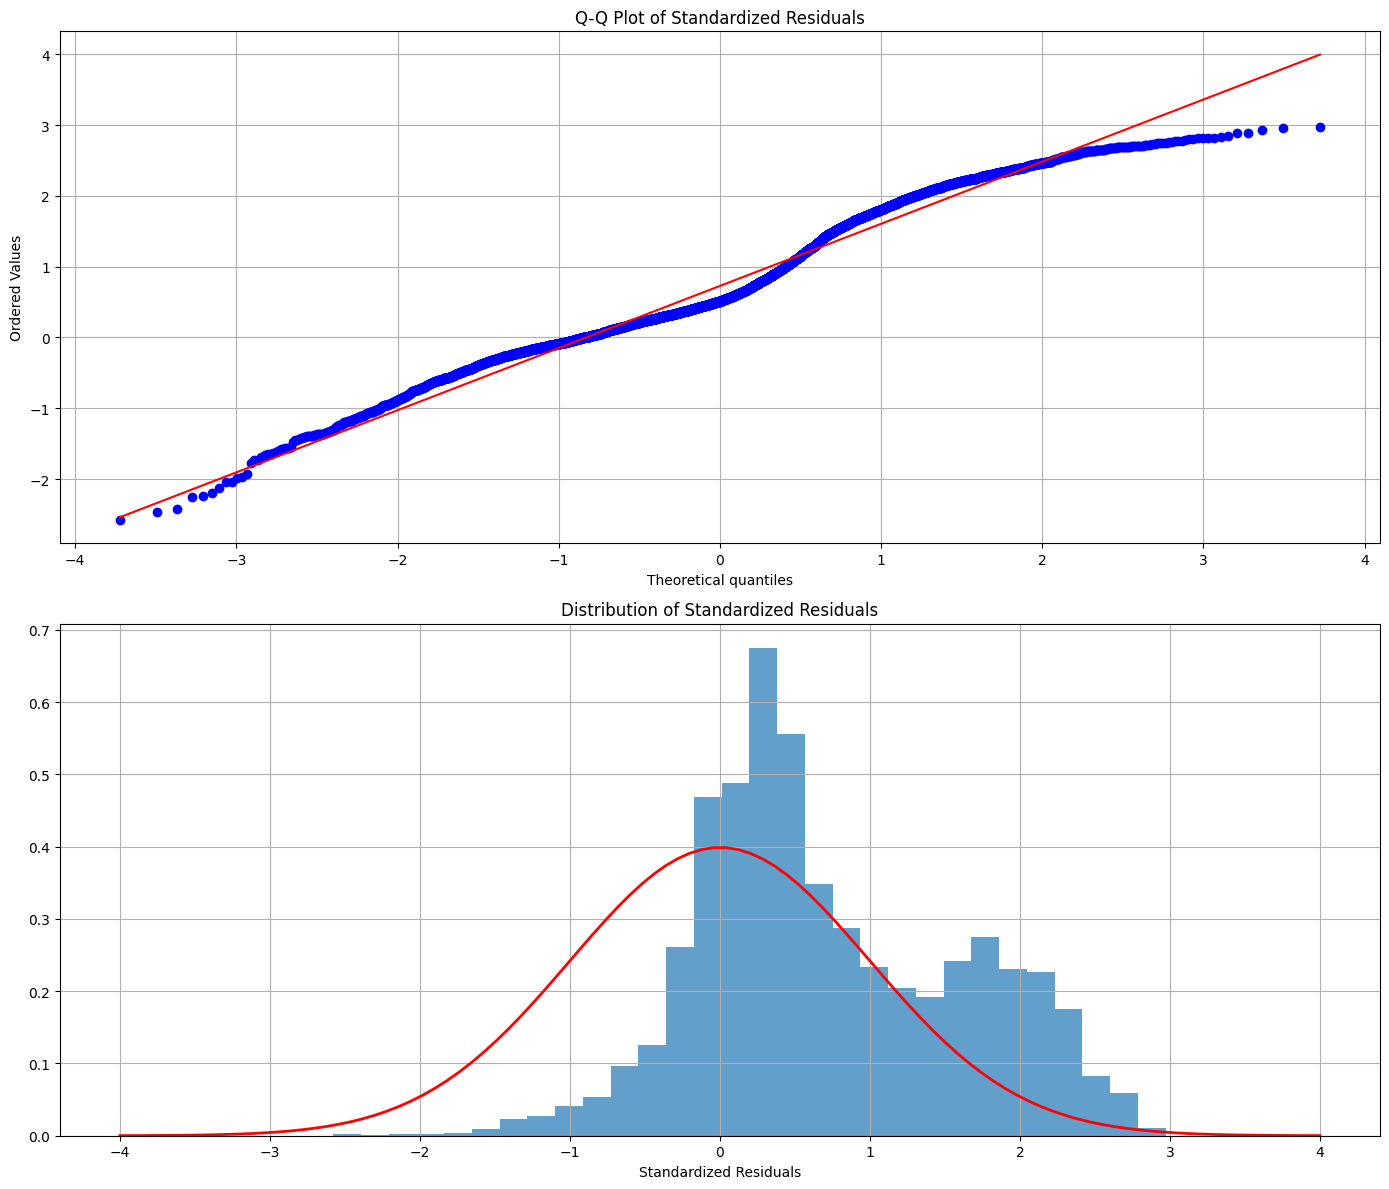

In [13]:
# Assumption check

def calculate_and_plot_aft_residuals(aft_model, df, duration_col="Tenure_in_Months"):
    """
    Calculate residuals for an AFT model and create diagnostic plots.
    
    Parameters:
    - aft_model: Fitted AFT model object
    - df: DataFrame containing the original data
    - duration_col: Name of the column containing duration values
    
    Returns:
    - Dictionary containing residual measures
    - Displays diagnostic plots
    """
    # Calculate residuals
    mu_features = aft_model.params_.loc['mu_'].index.tolist()
    if 'Intercept' in mu_features:
        mu_features.remove('Intercept')
    
    X = df[mu_features].copy()
    actual_durations = df[duration_col].values
    coefficients = aft_model.params_.loc['mu_'][mu_features].values
    Xbeta = np.dot(X, coefficients)
    log_residuals = np.log(actual_durations) - Xbeta
    scale = np.exp(aft_model.params_.loc['sigma_'][0])
    standardized_residuals = log_residuals / scale
    skewness_value = skew(standardized_residuals)
    
    print(f"Skewness: {skewness_value:.4f}")

    
    residuals = {
        'log_residuals': log_residuals,
        'standardized_residuals': standardized_residuals,
        'Xbeta': Xbeta,
        'actual_log_durations': np.log(actual_durations),
        'scale': scale
    }
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    stats.probplot(residuals['standardized_residuals'], dist="norm", plot=axes[0])
    axes[0].set_title('Q-Q Plot of Standardized Residuals')
    axes[0].grid(True)
    
    # Histogram of standardized residuals
    axes[1].hist(residuals['standardized_residuals'], bins=30, density=True, alpha=0.7)
    x = np.linspace(-4, 4, 100)
    axes[1].plot(x, stats.norm.pdf(x), 'r-', linewidth=2)
    axes[1].set_title('Distribution of Standardized Residuals')
    axes[1].set_xlabel('Standardized Residuals')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return residuals

residuals = calculate_and_plot_aft_residuals(aft, df)

In [14]:
## Appendix


# Plots to test the residuals for different groups 

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals_by_group(aft_model, df, group_col, duration_col='Tenure_in_Months'):
    """
    Plot standardized residuals grouped by a categorical variable to check for bias.
    Also prints mean residual per group.
    """
    # Calculate standardized residuals
    log_actual = np.log(df[duration_col].values)
    log_pred = np.log(aft_model.predict_median(df).values)
    scale = np.exp(aft_model.params_.loc['sigma_'][0])
    residuals = (log_actual - log_pred) / scale

    # Add to DataFrame
    df_copy = df.copy()
    df_copy['standardized_residuals'] = residuals

    
    # 👇 Print mean residual per group
    group_means = df_copy.groupby(group_col)['standardized_residuals'].mean()
    print(f"\nMean standardized residuals by {group_col}:\n{group_means.round(3)}")

    # Boxplot of residuals by group
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_copy, x=group_col, y='standardized_residuals')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Standardized Residuals by {group_col}")
    plt.ylabel("Standardized Residual")
    plt.xlabel(group_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [15]:
#plot_residuals_by_group(aft, df, group_col='Contract_One Year')

#plot_residuals_by_group(aft, df, group_col='Payment_Method_Credit Card')

In [16]:
df.columns

Index(['Age', 'Tenure_in_Months', 'Churn_status', 'gender_e', 'married_e',
       'paper_e', 'offer_e', 'Contract_e', 'Payment_Method_e',
       'Internet_Type_Fiber Optic'],
      dtype='object')